
# Bouncing Ball

The bouncing ball system is a classic example of a hybrid dynamical system, characterized by continuous dynamics interspersed with discrete events. This system models the motion of a ball under the influence of gravity and its elastic collisions with a flat surface.

### Physical Principles

The motion of the ball is governed by two main physical principles:

1. **Gravity:** The ball experiences a constant downward acceleration due to gravity, $g \approx 9.81 \, \text{m/s}^2$, which influences its vertical motion.
2. **Elastic Collisions:** When the ball makes contact with the ground, it undergoes an elastic collision, characterized by a coefficient of restitution $e$, where $0.0 \leq e \leq 1.0$. This coefficient determines the loss of velocity upon impact, with $e = 1.0$ representing a perfectly elastic collision (no energy loss) and $e = 0.0$ a perfectly inelastic collision (total energy loss).

### Mathematical Modeling

The system's state is represented by a vector $\mathbf{x} = [y, v]^T$, where $y$ is the height of the ball above the ground, and $v$ is its velocity. The dynamics of the ball before collision can be described by the following ordinary differential equations (ODEs):

$$
\begin{align*}
\frac{dy}{dt} &= v \\[5pt]
\frac{dv}{dt} &= -g
\end{align*}
$$

These equations model the continuous motion of the ball as it falls under gravity and ascends after bouncing, neglecting air resistance.

#### Collision Detection and Response

A key aspect of the bouncing ball system is detecting when the ball contacts the ground and appropriately updating its state. This involves:

- **Collision Detection:** Identifying when the ball's height, $y$, is zero, indicating contact with the ground.
- **Collision Response:** Updating the ball's velocity, $v$, based on the coefficient of restitution, $e$, using the relation $v_{\text{new}} = -e \cdot v_{\text{old}}$, to model the bounce.

### Implementation in the Collimator

This model is implemented in a Colimator as the `LeafSystem` shown below. The system:

- Defines continuous state variables for the ball's position and velocity.
- Implements ODEs for the motion under gravity.
- Handles collision detection and response through a zero-crossing event mechanism, ensuring accurate simulation of bounces.

In [1]:
import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt

import collimator
from collimator.simulation import SimulatorOptions

In [2]:
class BouncingBall(collimator.LeafSystem):
    def __init__(self, *args, g=9.81, e=1.0, **kwargs):
        super().__init__(*args, name="ball", **kwargs)

        self.e = e  # Resitiution coefficent (0.0 <= e <= 1.0)
        self.declare_continuous_state(2, ode=self.ode)  # Two state variables.
        self.declare_continuous_state_output(name="ball:y")
        self.declare_dynamic_parameter("g", g)

        self.declare_zero_crossing(
            guard=self._signed_distance,
            reset_map=self._reset,
            name="time_reset",
            direction="positive_then_non_positive",
        )

    def ode(self, time, state, **params):
        g = params["g"]
        y, v = state.continuous_state
        return jnp.array([v, -g])

    def _signed_distance(self, time, state, **params):
        y, v = state.continuous_state
        return y

    def _reset(self, time, state, **params):
        # Update velocity using Newonian restitution model.
        y, v = state.continuous_state

        return state.with_continuous_state(jnp.array([jnp.abs(y), -self.e * v]))

**Note:** Also see `testing.models` for an implementation using primitive blocks.

We can now define the parameters, initialize the states, create a system-context pair, simulate, and plot the results. We first start with $e=1.0$, implying that their is no loss of energy on collisions.

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=100, ode_solver_method=auto, rtol=1e-10, atol=1e-12, min_minor_step_size=None, max_minor_step_size=0.001, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=1, return_context=True), Dopri5Solver(system=BouncingBall(system_id=1, name='ball', ui_id=None, parent=None), rtol=1e-10, atol=1e-12, max_step_size=0.001, min_step_size=None, method='auto', enable_autodiff=False, supports_mass_matrix=False)


1.4278431229270645


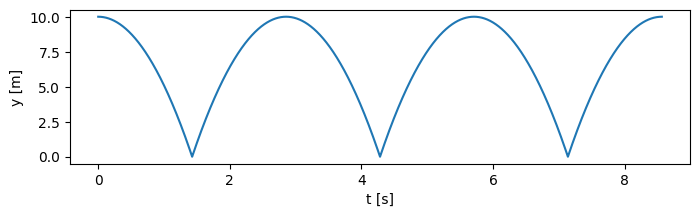

In [3]:
# parameters
g = 9.81
e = 1.0

# Define initial conditions
y0 = 10.0
t1 = np.sqrt(2 * y0 / g)  # time to first collision
print(t1)
x0 = np.array([y0, 0.0])

# system-context pair
system = BouncingBall(g=g, e=e)
context = system.create_context()
context = context.with_continuous_state(x0)

options = SimulatorOptions(
    max_major_steps=100,
    atol=1e-12,
    rtol=1e-10,
    max_minor_step_size=1e-3,
)
recorded_signals = {"y": system.output_ports[0]}

results = collimator.simulate(
    system,
    context,
    (0.0, 6 * t1),
    options=options,
    recorded_signals=recorded_signals,
)

t, y = results.time, results.outputs["y"]

fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.plot(t, y[:, 0])
ax.set_xlabel("t [s]")
ax.set_ylabel("y [m]")
plt.show()

Now lets assign $e=0.9$, so that the ball looses energy at every collision.

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=200, ode_solver_method=auto, rtol=1e-10, atol=1e-12, min_minor_step_size=None, max_minor_step_size=0.001, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=1, return_context=True), Dopri5Solver(system=BouncingBall(system_id=2, name='ball', ui_id=None, parent=None), rtol=1e-10, atol=1e-12, max_step_size=0.001, min_step_size=None, method='auto', enable_autodiff=False, supports_mass_matrix=False)


1.4278431229270645


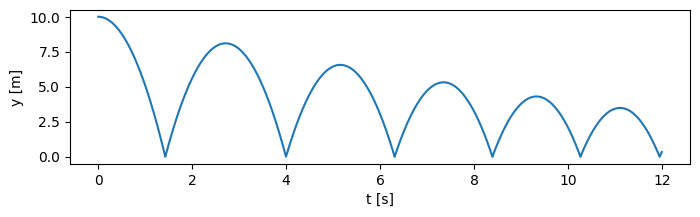

In [4]:
g = 9.81
e = 0.9

# Define initial conditions
y0 = 10.0
t1 = np.sqrt(2 * y0 / g)  # time to first collision
print(t1)
x0 = np.array([y0, 0.0])

diagram = BouncingBall(g=g, e=e)
context = diagram.create_context()
context = context.with_continuous_state(x0)

options = SimulatorOptions(
    max_major_steps=200,
    atol=1e-12,
    rtol=1e-10,
    max_minor_step_size=1e-3,
)
recorded_signals = {"y": diagram.output_ports[0]}
results = collimator.simulate(
    diagram, context, (0.0, 12.0), options=options, recorded_signals=recorded_signals
)

t, y = results.time, results.outputs["y"]

fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.plot(t, y[:, 0])
ax.set_xlabel("t [s]")
ax.set_ylabel("y [m]")
plt.show()

## Handling Zeno States

We now extend the bouncing ball model to explore the phenomenon of Zeno states, a situation where an infinite number of discrete events (bounces, in our case) occur in a finite time interval. This behavior presents a significant challenge for numerical simulation due to the potential for infinite recursion or failure to progress the simulation time. In the context of the bouncing ball model, this could theoretically occur if the ball bounces infinitely often as its energy approaches zero. While physically implausible due to energy dissipation and material properties, accurately simulating near-Zeno conditions is crucial for understanding system dynamics and stability.
To manage this, the `Integrator` block in Collimator consists of mechanisms to detect and handle Zeno conditions. 

We implement the above bouncing ball LeafSystem from primitive, particularly the `Integrator` block with `reset` events. The `reset` events are used to detect collisions and implement changes to the continuous states. For Zeno behaviour, the `Integrator` block takes a `zeno_tolerance` parameter. If the time between `Integrator` reset events is less than this tolerance, then the Integrator is considered to be in Zeno state, and the output of the Integrator is held constant. Exit from Zeno state occurs when the `reset` trigger port of the integrator changes from `True` to `False`. Please see the documentation of the `Integrator` block for more details.

In [5]:
from collimator.library import *


def make_diagram(g=10.0, e=1.0, zeno_tolerance=1e-6, floor_height=None):
    builder = collimator.DiagramBuilder()

    # Dynamics blocks
    integrator_v = builder.add(
        Integrator(
            initial_state=0.0,
            enable_reset=True,
            enable_external_reset=True,
            name="integrator_v",
            zeno_tolerance=zeno_tolerance,
        )
    )
    integrator_y = builder.add(
        Integrator(
            initial_state=0.0,
            enable_reset=True,
            enable_external_reset=True,
            name="integrator_y",
            zeno_tolerance=zeno_tolerance,
        )
    )
    constant = builder.add(Constant(-g, name="constant"))

    # Connect the dynamics blocks
    builder.connect(integrator_v.output_ports[0], integrator_y.input_ports[0])
    builder.connect(constant.output_ports[0], integrator_v.input_ports[0])

    # Reset blocks
    comparator = builder.add(ReduceBlock(2, lambda x: x[0] < x[1], name="comparator"))
    reset_v = builder.add(Gain(-e, name="reset_v"))

    if floor_height is None:
        floor_height = Constant(jnp.array(0.0), name="floor")
    builder.add(floor_height)

    # Connect the reset blocks
    builder.connect(integrator_y.output_ports[0], comparator.input_ports[0])
    builder.connect(floor_height.output_ports[0], comparator.input_ports[1])

    # Reset triggers
    builder.connect(comparator.output_ports[0], integrator_v.input_ports[1])
    builder.connect(comparator.output_ports[0], integrator_y.input_ports[1])

    # Reset values
    builder.connect(floor_height.output_ports[0], integrator_y.input_ports[2])
    builder.connect(integrator_v.output_ports[0], reset_v.input_ports[0])
    builder.connect(reset_v.output_ports[0], integrator_v.input_ports[2])

    return builder.build()

To examine Zeno behaviour handling, consider the setup below with the above diagram. We start with a small `y0 = 1e-03`  at `t=0`, and the floor height is `z=0` until `t=1.0`, when it changes to `z=-1e-03`.

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=0.1, max_major_steps=1000, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=0.001, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=1, return_context=True), Dopri5Solver(system=Diagram(root, 6 nodes), rtol=1e-06, atol=1e-08, max_step_size=0.001, min_step_size=None, method='auto', enable_autodiff=False, supports_mass_matrix=False)


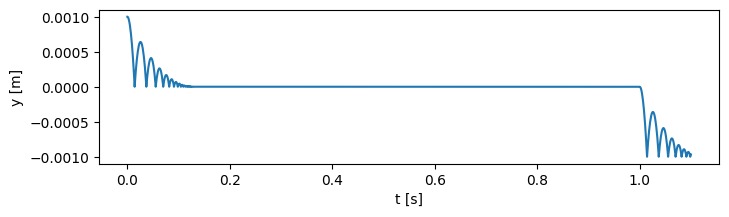

In [6]:
rtol = 1e-6
atol = 1e-8
g = 9.81
e = 0.8

# Define initial conditions
y0 = 1e-3

# floor_height = Constant(jnp.array(0.0), name="floor")
floor_height = Step(start_value=0.0, end_value=-y0, step_time=1.0, name="reset_y")

diagram = make_diagram(g=g, e=e, floor_height=floor_height)
context = diagram.create_context()
int_y = diagram["integrator_y"].system_id
int_context = context[int_y].with_continuous_state(y0)
context = context.with_subcontext(int_y, int_context)

options = SimulatorOptions(
    max_major_steps=1000,
    atol=atol,
    rtol=rtol,
    max_major_step_length=1e-1,
    max_minor_step_size=1e-3,
)
recorded_signals = {"y": diagram["integrator_y"].output_ports[0]}
results = collimator.simulate(
    diagram,
    context,
    (0.0, 1.1),
    options=options,
    recorded_signals=recorded_signals,
)

t, y = results.time, results.outputs["y"]

fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.plot(t, y)
ax.set_ylim(-1.1 * y0, 1.1 * y0)
ax.set_xlabel("t [s]")
ax.set_ylabel("y [m]")
plt.show()

We observe the bouncing ball, shortly after 0.1s, entering into a Zeno state. When the floor height is lowered at 1.0s, it exits the Zeno state.

In the setup below, we simulate the system from `y0 = 10`  at `t=0`, and the floor height is `z=5` until `t=10`, when it changes to `z=0`.

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=0.1, max_major_steps=10000, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=0.001, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=1, return_context=True), Dopri5Solver(system=Diagram(root, 6 nodes), rtol=1e-06, atol=1e-08, max_step_size=0.001, min_step_size=None, method='auto', enable_autodiff=False, supports_mass_matrix=False)


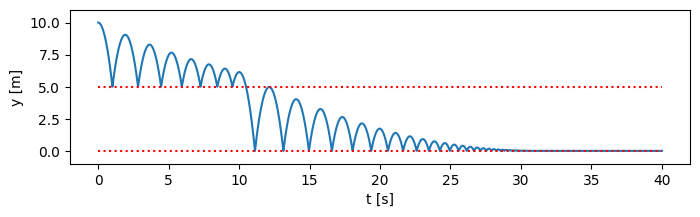

In [7]:
rtol = 1e-6
atol = 1e-8
g = 9.81
e = 0.9

# Define initial conditions
y0 = 10.0

# floor_height = Constant(jnp.array(0.0), name="floor")
floor_height = Step(start_value=5.0, end_value=0.0, step_time=10.0, name="reset_y")

diagram = make_diagram(g=g, e=e, floor_height=floor_height)
context = diagram.create_context()
int_y = diagram["integrator_y"].system_id
int_context = context[int_y].with_continuous_state(y0)
context = context.with_subcontext(int_y, int_context)

options = SimulatorOptions(
    max_major_steps=10000,
    atol=atol,
    rtol=rtol,
    max_major_step_length=1e-1,
    max_minor_step_size=1e-3,
)
recorded_signals = {"y": diagram["integrator_y"].output_ports[0]}
results = collimator.simulate(
    diagram,
    context,
    (0.0, 40.0),
    options=options,
    recorded_signals=recorded_signals,
)

t, y = results.time, results.outputs["y"]

fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.plot(t, y)
ax.set_ylim(-1.0, 1.1 * y0)
ax.set_xlabel("t [s]")
ax.set_ylabel("y [m]")
ax.hlines([5.0, 0.0], 0.0, t[-1], "r", "dotted")
plt.show()